# Meta-Labeling

Meta-labeling enhances decision making by introducing a secondary model that filters the primary model's predictions; while the primary model predicts a "side" (for example, whether an asset will go up or down), the meta-labeling framework uses the realized outcome to generate a binary indicator that reflects whether the prediction was correct, and then trains a meta-model to estimate the probability that the primary prediction is reliable, thereby enabling one to act only on signals that pass a predefined confidence threshold.


## Procedure

1. **Primary Model Prediction:**  
   Let the primary model be $f$ such that for an input $x_i$, it produces a side $s_i \in \{-1, +1\}$.

2. **Realized Outcome:**  
   For each observation, we have a realized outcome $r_i$ (e.g., the actual return after acting on $s_i$).

3. **Defining the Meta-Label:**  
   The meta-label $\ell_i$ is defined as:
   $$
   \ell_i =
   \begin{cases}
     1, & \text{if } s_i \times r_i > 0, \\
     0, & \text{otherwise}.
   \end{cases}
   $$

4. **Meta-Model Training:**  
   We train a secondary model $g(x_i, s_i)$ to estimate the probability:
   $$
   \hat{p}_i = g(x_i, s_i) \approx \mathbb{P}(\ell_i = 1 \mid x_i, s_i),
   $$
   using a logistic loss function:
   $$
   \mathcal{L}(g) = -\frac{1}{N}\sum_{i=1}^N \left[\ell_i \log g(x_i, s_i) + (1-\ell_i)\log(1 - g(x_i, s_i))\right].
   $$

5. **Decision Rule:**  
   At inference, we decide to act on the primary prediction $s_i$ if $g(x_i, s_i) > \alpha$, where $\alpha \in (0,1)$ is a chosen threshold.


In [20]:
import numpy as np
from sklearn.base import BaseEstimator

def train_meta_model(primary_model: BaseEstimator,
                     secondary_model: BaseEstimator,
                     X: np.ndarray,
                     realized_outcomes: np.ndarray) -> BaseEstimator:
    """
    Trains a secondary (meta) model to predict the correctness of the primary model's predictions.

    Parameters:
        primary_model (BaseEstimator): A trained model with a .predict() method that outputs labels {-1, +1}.
        secondary_model (BaseEstimator): A model with .fit() method that will learn to predict meta-labels.
        X (np.ndarray): Feature matrix of shape (n_samples, n_features).
        realized_outcomes (np.ndarray): Realized outcomes (e.g., returns) corresponding to each sample.

    Returns:
        secondary_model (BaseEstimator): The trained meta-model.
    """
    # Step 1: Use the primary model to predict the "side" for each observation.
    primary_preds = primary_model.predict(X)  # shape: (n_samples,)

    # Step 2: Generate meta-labels.
    # Meta-label is 1 if the predicted side is correct (i.e., s * r > 0), else 0.
    meta_labels = np.where(primary_preds * realized_outcomes > 0, 1, 0)

    # Step 3: Augment the original features with the primary model's predictions.
    # Here, we add the prediction as a new column.
    X_augmented = np.hstack([X, primary_preds.reshape(-1, 1)])

    # Step 4: Train the secondary model on the augmented feature set and meta-labels.
    secondary_model.fit(X_augmented, meta_labels)

    return secondary_model , X_augmented


In [21]:
cd /content/drive/MyDrive/Math 628/week 7

/content/drive/MyDrive/Math 628/week 7


In [22]:
from Labeling import *

In [23]:
! pip install ta
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, EMAIndicator, MACD

def compute_technical_indicators(data):
    """
    Computes technical indicators for a given dataset of a stock.

    Parameters:
    - data (pd.DataFrame): DataFrame containing stock data with columns:
                           ['Open', 'High', 'Low', 'Close', 'Volume']

    Returns:
    - pd.DataFrame: Enhanced DataFrame with additional columns for technical indicators and lagged returns.
    """
    # Ensure the dataset has the required columns
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Dataset must contain the following columns: {required_columns}")

    # Simple Moving Average (SMA)
    data['SMA_20'] = SMAIndicator(close=data['Close'], window=20).sma_indicator()
    data['SMA_50'] = SMAIndicator(close=data['Close'], window=50).sma_indicator()

    # Exponential Moving Average (EMA)
    data['EMA_20'] = EMAIndicator(close=data['Close'], window=20).ema_indicator()
    data['EMA_50'] = EMAIndicator(close=data['Close'], window=50).ema_indicator()

    # Relative Strength Index (RSI)
    data['RSI'] = RSIIndicator(close=data['Close'], window=14).rsi()

    # Moving Average Convergence Divergence (MACD)
    macd_indicator = MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
    data['MACD'] = macd_indicator.macd()
    data['MACD_Signal'] = macd_indicator.macd_signal()

    # Returns and lagged returns
    data['Return'] = data['Close'].pct_change()
    data['Lag_Return_1'] = data['Return'].shift(1)
    data['Lag_Return_2'] = data['Return'].shift(2)
    data['Lag_Return_3'] = data['Return'].shift(3)

    # Tomorrow's return (forward-looking)
    data['Tomorrow_Return'] = data['Return'].shift(-1)

    # Dropping NaN values caused by rolling calculations
    data = data.dropna()

    return data



In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


ticker = '^GSPC'
start_date = '1983-01-01'
end_date = '2023-01-01'
datasp = yf.download(ticker, start=start_date, end=end_date)
datasp.columns = ["Close", "High", "Low", "Open", "Volume" ]
prices = datasp['Close']

volatility = daily_volatility_with_log_returns(prices, 30)
filter_threshold = 1
moelcules = cusum_filter_events_dynamic_threshold(np.log(prices), filter_threshold * volatility)
vertical_barriers = vertical_barrier(prices, moelcules, 20)


triple_barrier_events ,tt = meta_events(prices, vertical_barriers.index, [1.5, 1.5], volatility, 0, 1, vertical_barriers)
labels = meta_labeling(triple_barrier_events, prices)


[*********************100%***********************]  1 of 1 completed


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc)



combined_data = pd.merge(compute_technical_indicators(datasp), labels, left_index=True, right_index=True)

data = combined_data.copy()
# Assume apple_new is a pre-loaded DataFrame with your data
selected_columns = ['SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'RSI',
                    'MACD', 'MACD_Signal', 'Return', 'Lag_Return_1',
                    'Lag_Return_2', 'Lag_Return_3']

# Filter the dataset to include only rows with label -1 and 1
data = data[data['Label'].isin([-1, 1])]

features = data[selected_columns]
target = data['Label'].values

In [54]:
n = len(data)
train_end = int(0.7 * n)
secondary_end = int(0.9 * n)


X_train = features.iloc[:train_end]
y_train = target[:train_end]

X_secondary = features.iloc[train_end:secondary_end]
y_secondary = target[train_end:secondary_end]

X_test = features.iloc[secondary_end:]
y_test = target[secondary_end:]

In [30]:
primary_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced' , random_state=42)
secondary_model = RandomForestClassifier(n_estimators=100, class_weight='balanced' , random_state=42)
primary_model.fit(X_train, y_train)

secondary_model, X_aug = train_meta_model(primary_model, secondary_model, X_secondary, y_secondary)

In [45]:
X_test

,SMA_20,SMA_50,EMA_20,EMA_50,RSI,MACD,MACD_Signal,Return,Lag_Return_1,Lag_Return_2,Lag_Return_3,Primary_Prediction
2019-04-01,2807.717480,2760.233394,2810.449964,2765.430502,65.610442,22.060455,22.279346,0.011569,0.006734,0.003589,-0.004644,-1.0
2019-04-05,2830.700977,2778.795991,2833.140940,2782.166291,69.790708,29.220501,25.079970,0.004636,0.002085,0.002148,0.000017,-1.0
2019-04-12,2852.761475,2801.278984,2856.437303,2802.052628,69.388307,30.567762,28.508782,0.006609,0.000038,0.003478,-0.006067,-1.0
2019-04-23,2878.565479,2824.181582,2881.195269,2825.188224,73.028052,29.665678,29.266042,0.008841,0.001012,0.001579,-0.002274,-1.0
2019-04-29,2901.698474,2839.842378,2898.895839,2841.336140,72.915128,30.211713,29.631898,0.001072,0.004685,-0.000369,-0.002192,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,3718.754504,3842.010815,3761.033984,3820.372702,59.487245,8.411950,-27.137283,0.024626,-0.006083,-0.007388,0.016267,-1.0
2022-11-02,3730.511011,3821.862212,3777.747117,3821.207313,48.477624,14.836953,-5.819047,-0.025002,-0.004101,-0.007454,0.024626,-1.0
2022-11-07,3745.544519,3799.856011,3775.383280,3815.065951,52.194631,7.836278,0.584467,0.009614,0.013619,-0.010586,-0.025002,-1.0
2022-11-09,3766.085022,3791.054214,3777.372996,3812.949744,47.672676,6.474139,3.380661,-0.020778,0.005598,0.009614,0.013619,-1.0


In [31]:
def compute_pl_for_stratgy(data, features , primary_model , secondary_model , threshold = 0.55):
  label = primary_model.predict(features)
  features['Primary_Prediction'] = label
  prob = secondary_model.predict_proba(features)[:, 1]
  new_data = data.loc[features.index]
  new_data['label'] = label
  new_data['prob'] = prob
  new_data = new_data[new_data['prob'] > threshold]
  invest_length = (new_data['End Time'] - new_data.index).dt.days.astype(int)
  returns =  new_data['Return of Label'] * new_data['label'] * new_data['prob']

  return returns

In [32]:
meta_labeling_result = compute_pl_for_stratgy(data , X_test , primary_model , secondary_model)

<ipython-input-31-c1cbc24dc7c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Primary_Prediction'] = label
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [46]:
meta_labeling_result

,0
2019-04-01,-0.009960
2019-04-05,-0.009341
2019-04-12,-0.007929
2019-04-23,0.013026
2019-04-29,0.007281
...,...
2022-10-28,0.031890
2022-11-02,-0.044466
2022-11-07,-0.032218
2022-11-09,-0.045456


<Axes: >

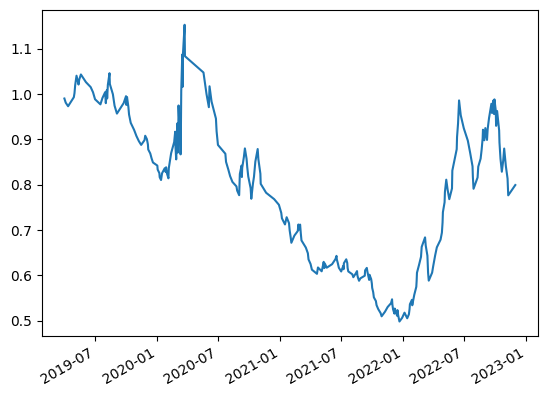

In [34]:
returns = (meta_labeling_result +1).cumprod()
returns.plot()

# Mixture of Guassian betsizing
## 1. Concurrency Variable

Let $\{c_t\}_{t \in \mathcal{T}}$ be a univariate random variable capturing the “concurrency” at time $t$. In many financial contexts, $c_t$ measures the net number of overlapping signals or events at time $t$. For example:

- $c_t > 0$ indicates a net positive concurrency (more long/positive events overlapping than negative ones).
- $c_t < 0$ indicates a net negative concurrency.

We wish to convert $c_t$ into a bet size $m_t \in [0,1]$ that scales our position or leverage according to how “extreme” $c_t$ is relative to its distribution.

---

## 2. Gaussian Mixture Model (GMM)

We model $c_t$ as coming from a univariate mixture of $K$ Gaussians. That is, the probability density function (PDF) of $c_t$ is given by

$$
f(c) \;=\; \sum_{i=1}^K \pi_i \,\mathcal{N}\!\bigl(c \mid \mu_i,\, \sigma_i^2\bigr),
$$

where:

1. $\pi_i > 0$ are *mixture weights* (with $\sum_{i=1}^K \pi_i = 1$).
2. $\mu_i \in \mathbb{R}$ are the *component means*.
3. $\sigma_i^2 > 0$ are the *component variances*.
4. $\mathcal{N}(x \mid \mu,\sigma^2)$ is the standard Gaussian PDF with mean $\mu$ and variance $\sigma^2$.

### 2.1. Mixture CDF

The *cumulative distribution function* (CDF) $F(c)$ of this mixture is

$$
F(c) \;=\; \sum_{i=1}^K \pi_i \,\Phi\!\Bigl(\tfrac{c - \mu_i}{\sigma_i}\Bigr),
$$

where $\Phi$ is the standard normal CDF:

$$
\Phi(z) \;=\; \int_{-\infty}^{z} \frac{1}{\sqrt{2\pi}} e^{-\frac{u^2}{2}}\,du.
$$

Thus, $F(c)$ gives the probability that the concurrency value is $\le c$.

---

## 3. Piecewise Bet Size Definition

We define a special point $F_0 := F(0)$, i.e., the mixture CDF evaluated at $0$. The bet size $m_t$ at time $t$ depends on the sign of $c_t$:

$$
m_t \;=\;
\begin{cases}
\dfrac{F[c_t] \;-\; F_0}{1 \;-\; F_0}, & \text{if } c_t \ge 0,\\[1.0em]
\dfrac{F[c_t] \;-\; F_0}{F_0}, & \text{if } c_t < 0.
\end{cases}
$$

### 3.1. Interpretation

1. **Case $c_t \ge 0$:**  
   The numerator $F[c_t] - F_0$ measures how far $c_t$ is above 0 in terms of the mixture’s distribution. Dividing by $(1 - F_0)$ “normalizes” that excess so that $m_t$ lies in $[0,1]$.  
   - If $c_t = 0$, then $m_t = 0$.  
   - If $c_t$ is very large, $F[c_t] \approx 1$, hence $m_t \approx 1$.

2. **Case $c_t < 0$:**  
   The numerator is the same, $F[c_t] - F_0$, but now we normalize by $F_0$. Because $F[c_t] < F_0$ when $c_t < 0$, the ratio remains within $[-1,0)$ if taken literally. However, by definition, we interpret that ratio in a way that also yields a value in $[0,1]$ (or $[-1,1]$ in some contexts).  
   - If $c_t$ is very negative, $F[c_t] \approx 0$, so $m_t \approx (0 - F_0)/F_0 = -1$. Depending on conventions, we might map that to a 0–1 scale or allow negative bet sizes if short positions are permitted.



## 4. Summary of the Procedure

1. **Fit a GMM:**  
   Given a sample $\{c_1,\dots,c_n\}$, estimate $\{\pi_i,\mu_i,\sigma_i^2\}$ by maximum likelihood (e.g., the EM algorithm) for a univariate mixture of $K$ Gaussians.

2. **Compute $F(c)$:**  
   For each concurrency $c$, compute the CDF:

   $$
   F(c) \;=\; \sum_{i=1}^K \pi_i \,\Phi\!\Bigl(\tfrac{c - \mu_i}{\sigma_i}\Bigr).
   $$

3. **Identify $F_0$:**  
   Evaluate $F_0 = F(0)$.

4. **Map $c_t$ to $m_t$:**  
   For each concurrency value $c_t$, define

   $$
   m_t =
   \begin{cases}
     \dfrac{F[c_t] - F_0}{1 - F_0}, & \text{if } c_t \ge 0,\\[0.75em]
     \dfrac{F[c_t] - F_0}{F_0}, & \text{if } c_t < 0.
   \end{cases}
   $$

The result is a bet size $m_t \in [0,1]$ that grows larger as $c_t$ becomes more extreme in either the positive or negative direction.


In [35]:
import pandas as pd
import numpy as np

def compute_concurrency(events: pd.DataFrame,
                        end_time_col: str = 'end_time',
                        compute_uniqueness: bool = True
                       ) -> pd.DataFrame:
    """
    Compute the concurrency (number of overlapping events) for each row in `events`.
    Optionally compute the uniqueness weight = 1 / concurrency.

    Parameters
    ----------
    events : pd.DataFrame
        DataFrame of events where:
          - The index is the start time of each event.
          - `end_time_col` indicates the end time of each event.
    end_time_col : str
        Column name for the end time in `events`.
    compute_uniqueness : bool
        If True, also compute the uniqueness weight 1/concurrency.

    Returns
    -------
    events_concurrency : pd.DataFrame
        A copy of the input events DataFrame with two new columns:
          - 'concurrency': the concurrency count C_i
          - 'uniqueness': (optionally) 1 / concurrency
    """
    # Ensure the DataFrame is sorted by index (start time)
    events = events.copy()
    events.sort_index(inplace=True)

    # Prepare columns for concurrency and uniqueness
    concurrency_list = []

    start_times = events.index
    end_times = events[end_time_col]

    # Convert index (start times) and end times to arrays for faster access
    start_times_positive = events[events['Label'] > 0 ].index
    end_times_positive = events[events['Label'] > 0 ][end_time_col]

    start_times_negative = events[events['Label'] < 0 ].index
    end_times_negative = events[events['Label'] < 0 ][end_time_col]

    # Naive O(N^2) approach: for each event i, count how many j overlap
    for i in range(len(events)):
        start_i = start_times[i]
        end_i = end_times.iloc[i]


        overlapping_positive = ((start_times_positive < end_i) & (end_times_positive >  start_i))
        overlapping_negative = ((start_times_negative < end_i) & (end_times_negative >  start_i))

        concurrency_count = overlapping_positive.sum() - overlapping_negative.sum()
        concurrency_list.append(concurrency_count)

    events['concurrency'] = concurrency_list


    return events



In [36]:
concurrent = compute_concurrency(labels[labels['Label'].isin([-1, 1])] , 'End Time')

In [37]:
from sklearn.mixture import GaussianMixture


concurrency_values = concurrent['concurrency'][:secondary_end].values.reshape(-1, 1)

# Choose number of components, for example 2
n_components = 2
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(concurrency_values)

GaussianMixture(n_components=2, random_state=42)

In [38]:
concurrent['concurrency'][secondary_end : ]

,concurrency
2019-02-04,3
2019-02-12,3
2019-03-01,0
2019-03-06,2
2019-03-08,3
...,...
2022-10-28,-2
2022-11-02,2
2022-11-07,3
2022-11-09,3


In [39]:
import numpy as np
from scipy.stats import norm

def gmm_cdf_single(gmm, x: float) -> float:
    """
    Compute the CDF of a univariate Gaussian Mixture Model at a single value x.

    Parameters:
      gmm: A fitted GaussianMixture instance from scikit-learn.
      x: A scalar at which to evaluate the CDF.

    Returns:
      The CDF evaluated at x.
    """
    cdf = 0.0
    for weight, mean, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        # Extract scalar mean and standard deviation.
        mu = mean[0] if isinstance(mean, np.ndarray) else mean
        sigma = np.sqrt(cov[0][0]) if cov.ndim > 1 else np.sqrt(cov)
        cdf += weight * norm.cdf(x, loc=mu, scale=sigma)
    return cdf

def gmm_cdf_array(gmm: GaussianMixture, x_array: np.ndarray) -> np.ndarray:
    """
    Compute the CDF of a univariate Gaussian Mixture Model for each value in x_array (vectorized).
    """
    # Ensure x_array is 1D
    x_array = x_array.ravel()
    cdf_vals = np.zeros_like(x_array, dtype=float)
    for weight, mean, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        mu = mean[0] if mean.ndim else mean
        sigma = np.sqrt(cov[0][0]) if cov.ndim > 1 else np.sqrt(cov)
        cdf_vals += weight * norm.cdf(x_array, loc=mu, scale=sigma)
    return cdf_vals

In [40]:
def compute_m_column(events, gmm, concurrency_col='concurrency', m_col='m'):


    # Copy to avoid modifying original
    events_out = events.copy()

    # 1) Compute F(0)
    F0 = gmm_cdf_single(gmm, 0.0)

    # 2) Compute concurrency array and its GMM CDF
    c_values = events_out[concurrency_col].values
    F_c = gmm_cdf_array(gmm, c_values)  # This gives F[c_t] for each row

    # 3) Apply piecewise definition:
    #    m_t = (F[c_t] - F0) / (1 - F0) if c_t >= 0
    #          (F[c_t] - F0) / F0      if c_t < 0
    m_values = np.where(
        c_values >= 0,
        (F_c - F0) / (1.0 - F0),
        (F_c - F0) / F0
    )

    # Store the result
    events_out[m_col] = m_values

    return events_out


In [41]:
gussian_output = compute_m_column(concurrent[secondary_end: ] , gmm)

In [42]:
returns = gussian_output['Return of Label'] * gussian_output['m']

In [43]:
returns

,0
2019-02-04,0.018151
2019-02-12,0.015670
2019-03-01,-0.000000
2019-03-06,0.007920
2019-03-08,0.012885
...,...
2022-10-28,0.017633
2022-11-02,0.022503
2022-11-07,0.028661
2022-11-09,0.040438


<Axes: >

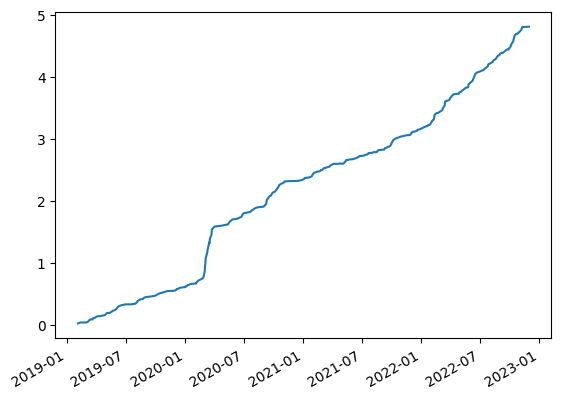

In [44]:
returns.cumsum().plot()

## Whats wrong?

# Z-statistics for BetSizing

We have a binary label $x \in \{-1,+1\}$ and a predicted probability $p = \Pr(x=+1)$. We test $H_0: p=0.5$ by computing the *z*-score:

$$
z = \frac{2p - 1}{2 \,\sqrt{p(1-p)}},
$$

which measures how many “standard deviations” $p$ is above/below 0.5. We then convert $z$ into a bet size $m \in [-1,1]$ via

$$
m = 2\,\Phi(z) - 1,
$$

where $\Phi$ is the standard normal CDF. As $p$ moves away from 0.5, $z$ grows in magnitude, and $m$ approaches $\pm1$. Hence $m>0$ indicates a long bet on $x=+1$, $m<0$ indicates a short bet on $x=-1$, and $|m|$ reflects confidence.


In [47]:
def z_stat_bet_size(p_array: np.ndarray) -> np.ndarray:

    p_array = np.clip(p_array, 1e-9, 1 - 1e-9)

    # Compute z-score for each probability
    z_vals = (2 * p_array - 1) / (2 * np.sqrt(p_array * (1 - p_array)))

    # Convert z to bet sizes: m = 2*Phi(z) - 1
    m_vals = 2 * norm.cdf(z_vals) - 1
    return m_vals


In [48]:
def compute_pl_for_stratgy(data, features , model , threshold = 0.55):
  label = model.predict(features)
  prob =  model.predict_proba(features)[:, 1]
  new_data = data.loc[features.index]
  new_data['m'] = z_stat_bet_size(prob)

  returns =  new_data['Return of Label']  * new_data['m']

  return returns

In [55]:

combined_data = pd.merge(compute_technical_indicators(datasp), labels, left_index=True, right_index=True)

data = combined_data.copy()
# Assume apple_new is a pre-loaded DataFrame with your data
selected_columns = ['SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'RSI',
                    'MACD', 'MACD_Signal', 'Return', 'Lag_Return_1',
                    'Lag_Return_2', 'Lag_Return_3']

# Filter the dataset to include only rows with label -1 and 1
data = data[data['Label'].isin([-1, 1])]

features = data[selected_columns]
target = data['Label'].values

X_train = features.iloc[:secondary_end]
y_train = target[:secondary_end]

model = RandomForestClassifier(n_estimators=500, class_weight='balanced' , random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42)

In [57]:
z_stat = compute_pl_for_stratgy(data , X_test , model)

<Axes: >

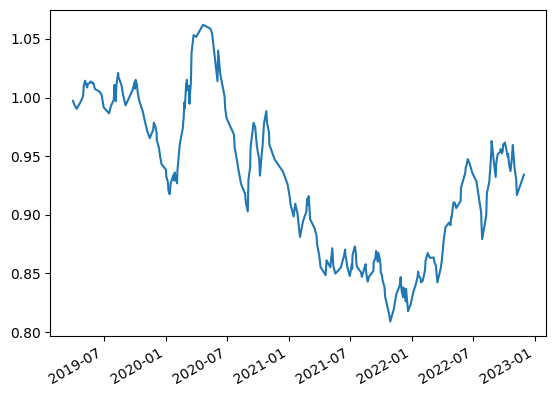

In [58]:
returns = (z_stat +1).cumprod()
returns.plot()

# Gaussian Mixture Models

A Gaussian Mixture Model assumes that the observed data $\mathbf{x} \in \mathbb{R}^D$ are generated from a combination of $K$ Gaussian distributions. The model is given by the probability density function

$$
p(\mathbf{x}|\Theta) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k),
$$

where:  
- $K$ is the number of Gaussian components,  
- $\pi_k$ is the mixing coefficient for the $k$th component (with $\pi_k \geq 0$ and $\sum_{k=1}^{K}\pi_k = 1$),  
- $\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)$ is the multivariate Gaussian density defined as  

$$
\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}_k|^{1/2}} \exp\!\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu}_k)^\top\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}-\boldsymbol{\mu}_k)\right).
$$

The complete set of parameters is $\Theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}_{k=1}^{K}$.

---

## Latent Variable Representation

To account for the mixture, we introduce a latent variable $z$ for each observation, where $z \in \{1,2,\dots,K\}$ indicates the component from which the observation is drawn. The complete-data likelihood (assuming we knew $z$) for a single observation $\mathbf{x}_i$ is

$$
p(\mathbf{x}_i, z_i=k|\Theta) = \pi_k \, \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k).
$$

Thus, the complete-data log-likelihood for the entire dataset $\{\mathbf{x}_i\}_{i=1}^N$ is

$$
\log p(\mathbf{X}, \mathbf{Z}|\Theta) = \sum_{i=1}^{N} \sum_{k=1}^{K} \mathbf{1}_{\{z_i=k\}} \left[ \log \pi_k + \log \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \right],
$$

where $\mathbf{1}_{\{z_i=k\}}$ is an indicator function equal to 1 if $z_i=k$ and 0 otherwise.

Because the $z_i$ are unobserved, we need to maximize the marginal likelihood

$$
p(\mathbf{X}|\Theta) = \prod_{i=1}^{N} \sum_{k=1}^{K} \pi_k \, \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k),
$$

which is challenging due to the sum inside the product.

---

## The Expectation-Maximization (EM) Algorithm

The EM algorithm provides an iterative approach for finding the maximum likelihood estimates of parameters when latent variables are present.

### E-Step: Compute Responsibilities

At the $t$th iteration, given current estimates $\Theta^{(t)} = \{\pi_k^{(t)}, \boldsymbol{\mu}_k^{(t)}, \boldsymbol{\Sigma}_k^{(t)}\}$, we calculate the posterior probability (responsibility) that component $k$ was responsible for generating data point $\mathbf{x}_i$:

$$
\gamma_{ik}^{(t)} = p(z_i=k|\mathbf{x}_i,\Theta^{(t)}) = \frac{\pi_k^{(t)} \, \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k^{(t)}, \boldsymbol{\Sigma}_k^{(t)})}{\sum_{j=1}^{K} \pi_j^{(t)} \, \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_j^{(t)}, \boldsymbol{\Sigma}_j^{(t)})}.
$$

This step computes the expected value of the complete-data log-likelihood, conditioning on the observed data.

### M-Step: Update Parameters

Using the responsibilities $\gamma_{ik}^{(t)}$, we update the parameters to maximize the expected complete-data log-likelihood.

1. **Mixing Coefficients:**

   Define the effective number of samples assigned to component $k$:

   $$
   N_k^{(t)} = \sum_{i=1}^{N} \gamma_{ik}^{(t)}.
   $$

   Update $\pi_k$ as

   $$
   \pi_k^{(t+1)} = \frac{N_k^{(t)}}{N}.
   $$

2. **Means:**

   The updated mean for component $k$ is computed as the weighted average of the data points:

   $$
   \boldsymbol{\mu}_k^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i=1}^{N} \gamma_{ik}^{(t)} \mathbf{x}_i.
   $$

3. **Covariance Matrices:**

   The updated covariance matrix is given by

   $$
   \boldsymbol{\Sigma}_k^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i=1}^{N} \gamma_{ik}^{(t)} \left(\mathbf{x}_i - \boldsymbol{\mu}_k^{(t+1)}\right)\left(\mathbf{x}_i - \boldsymbol{\mu}_k^{(t+1)}\right)^\top.
   $$

These updates guarantee that the likelihood does not decrease at each iteration.

### Convergence

The algorithm alternates between the E-step and M-step until convergence. Convergence is typically determined by checking if the change in the log-likelihood or the change in parameter values between iterations is below a predefined threshold. Note that while the EM algorithm guarantees non-decreasing likelihood, it may converge to a local maximum rather than the global maximum.

